<a href="https://colab.research.google.com/github/didi-d92/Time-series-forecasting-Rossman-store-sales/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install opendatasets --upgrade --quiet

In [72]:
!pip install numpy pandas-profiling matplotlib plotly seaborn --quiet

In [73]:
!pip install prophet


In [74]:
import os
import matplotlib.pyplot as plt
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [76]:
info= pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)

In [77]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [78]:
info.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


In [79]:
duplicados= info.duplicated().sum()

In [80]:
print(duplicados)

0


Date

In [81]:
data= info.copy()

In [82]:
data['Date'] = pd.to_datetime(data['Date'])

In [83]:
data['Month'] = data['Date'].dt.to_period('M')

In [84]:
data['Year'] = data['Date'].dt.year

In [85]:
print(data.head())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday    Month  Year  
0              1  2015-07  2015  
1              1  2015-07  2015  
2              1  2015-07  2015  
3              1  2015-07  2015  
4              1  2015-07  2015  


Daily Sales

In [86]:
daily_sales = data.groupby('Date').agg({
    'Sales': 'sum',
    'Open': 'sum',
    'Promo': 'sum',
    'StateHoliday' :'sum',
    'SchoolHoliday': 'sum'
}).reset_index()

Monthly Sales

In [87]:
monthly_sales = data.groupby('Month').agg({
    'Sales': 'sum',
    'Open': 'sum',
    'Promo': 'sum',
    'StateHoliday' :'sum',
    'SchoolHoliday': 'sum'
}).reset_index()

yearly sale

In [88]:
yearly_sales = data.groupby('Year').agg({
    'Sales': 'sum',
    'Open': 'sum',
    'Promo': 'sum',
    'StateHoliday' :'sum',
    'SchoolHoliday': 'sum'
}).reset_index()

#EDA

Trend

In [89]:
daily_sales['Year'] = daily_sales['Date'].dt.year
daily_sales['Month'] = daily_sales['Date'].dt.month

In [90]:
trend= daily_sales.groupby(['Year', 'Month'])['Sales'].sum().unstack(level=0)

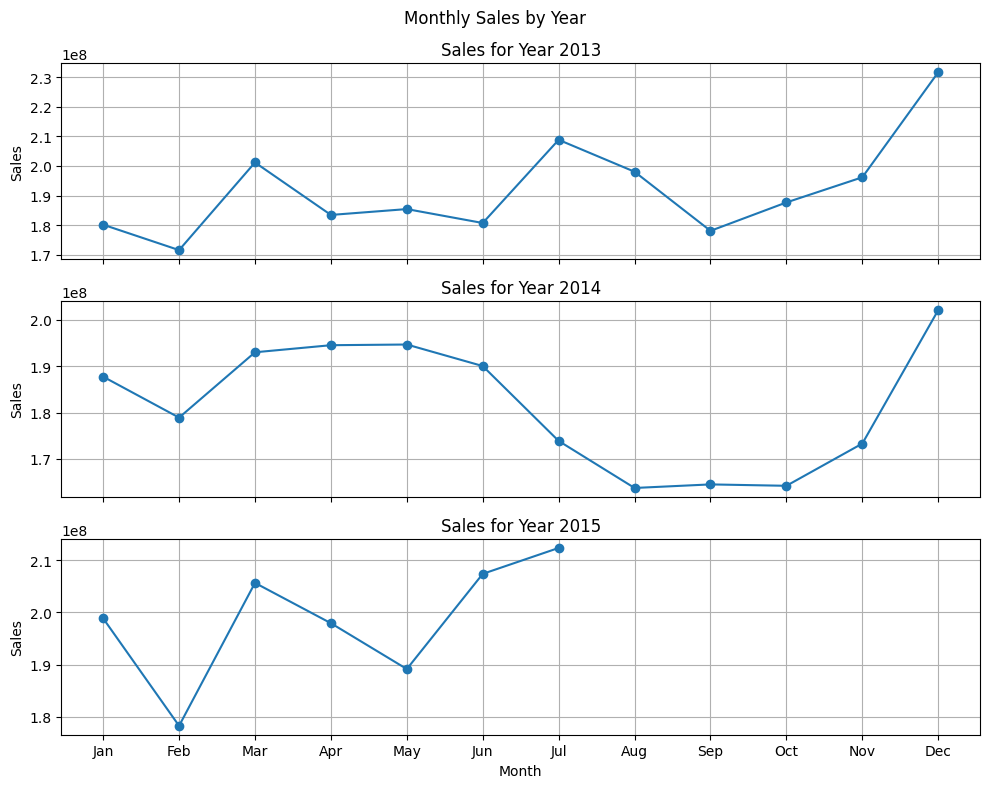

In [91]:
fig, axes = plt.subplots(nrows=trend.shape[1], ncols=1, figsize=(10, 8), sharex=True)
for idx, year in enumerate(trend.columns):
    axes[idx].plot(trend.index, trend[year], marker='o')
    axes[idx].set_title(f'Sales for Year {year}')
    axes[idx].set_ylabel('Sales')
    axes[idx].grid(True)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig.suptitle('Monthly Sales by Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

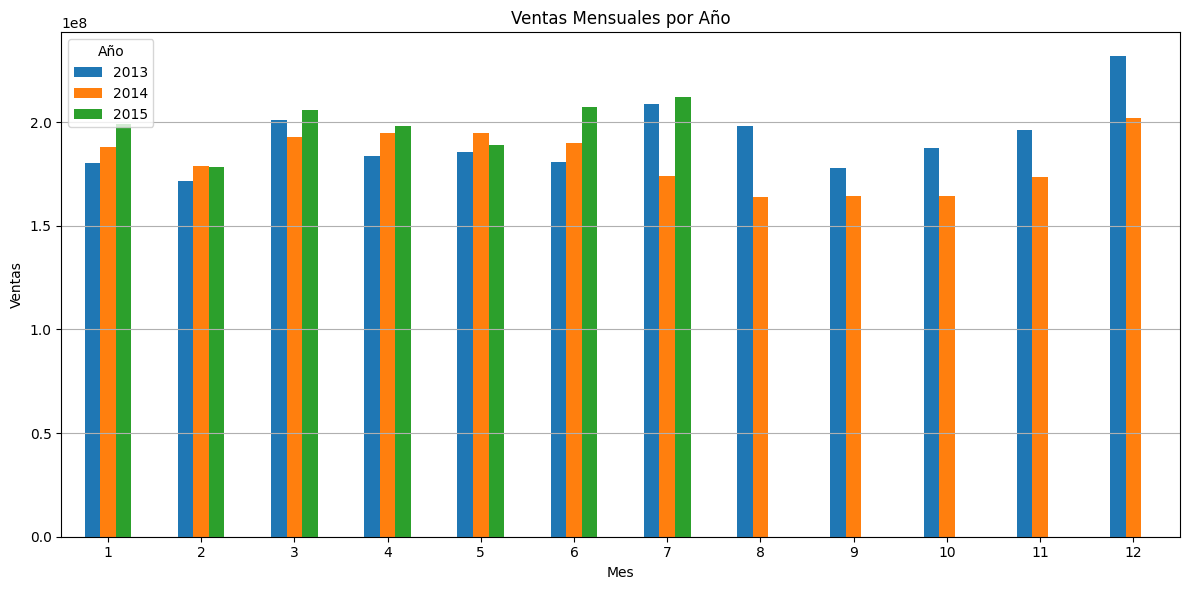

In [92]:
trend.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('Ventas Mensuales por Año')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(ticks=range(len(trend.index)), labels=trend.index, rotation=0)
plt.legend(title='Año')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

outliers en ventas

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


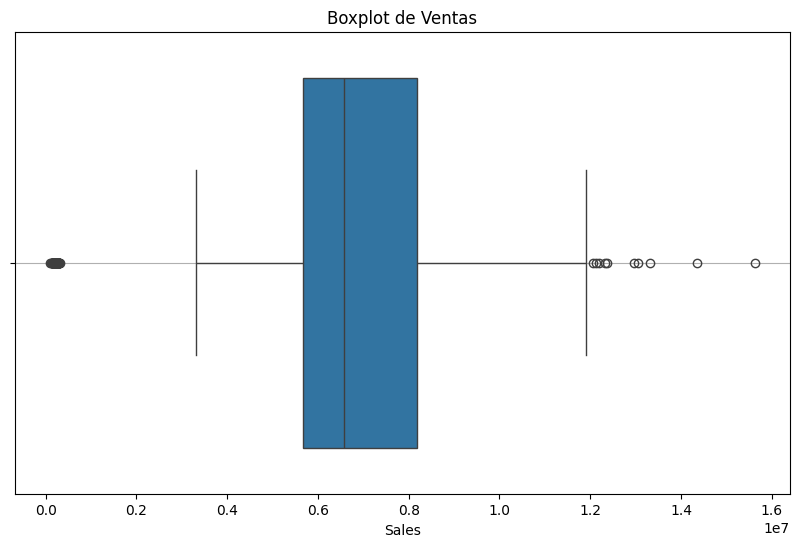

In [93]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=daily_sales['Sales'])
plt.title('Boxplot de Ventas')
plt.xlabel('Sales')
plt.grid(axis='y')
plt.show()

IQR

In [94]:
Q1 = daily_sales['Sales'].quantile(0.25)
Q3 = daily_sales['Sales'].quantile(0.75)
IQR = Q3 - Q1

In [95]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [96]:
outliers = daily_sales[(daily_sales['Sales'] < lower_bound) | (daily_sales['Sales'] > upper_bound)]
print(outliers)

          Date   Sales  Open  Promo  \
0   2013-01-01   97235    17      0   
5   2013-01-06  143904    19      0   
12  2013-01-13  144052    18      0   
19  2013-01-20  151600    19      0   
26  2013-01-27  142848    20      0   
..         ...     ...   ...    ...   
908 2015-06-28  262669    32      0   
915 2015-07-05  269248    33      0   
922 2015-07-12  277047    32      0   
929 2015-07-19  298418    32      0   
936 2015-07-26  285865    32      0   

                                          StateHoliday  SchoolHoliday  Year  \
0    aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...           1114  2013   
5    000000000000a00a000aaa00000a000a000aa000a0000a...            112  2013   
12   0000000000000000000000000000000000000000000000...              0  2013   
19   0000000000000000000000000000000000000000000000...              0  2013   
26   0000000000000000000000000000000000000000000000...              0  2013   
..                                                 ...   

In [97]:
print(daily_sales['Sales'].describe())


count    9.420000e+02
mean     6.234799e+06
std      3.130536e+06
min      9.723500e+04
25%      5.675832e+06
50%      6.580354e+06
75%      8.174899e+06
max      1.562355e+07
Name: Sales, dtype: float64


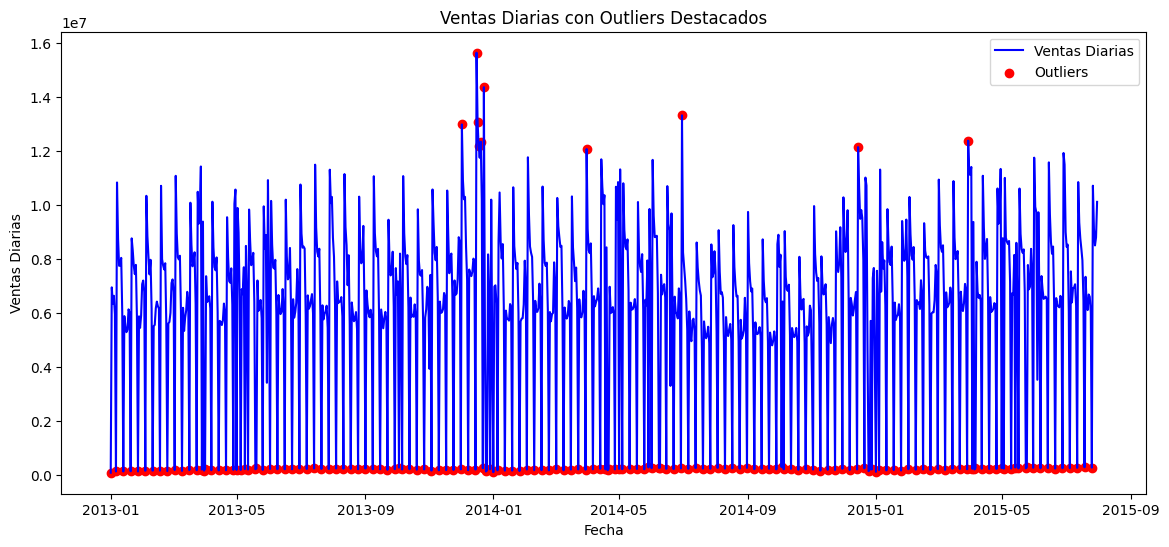

In [98]:
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Ventas Diarias', color='blue')
plt.scatter(outliers['Date'], outliers['Sales'], color='red', label='Outliers')
plt.xlabel('Fecha')
plt.ylabel('Ventas Diarias')
plt.title('Ventas Diarias con Outliers Destacados')
plt.legend()
plt.show()

La mayoría de los outliers tienen Promo = 0, lo que indica que estas ventas altas no se deben a promociones.
Pero coinciden con los cambios de estaciones en alemania y con navidad.
Por el momento decidi dejarlos, si en un futuro la predicción no es satifiscatoria voy a tener más factores en cuenta.

#Prophet

In [99]:
from prophet import Prophet


In [100]:
ds_prophet = daily_sales[['Date', 'Sales']].copy()

In [101]:
ds_prophet.columns = ['ds', 'y']

In [102]:
model = Prophet()
model.fit(ds_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/aia4nl_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/9fpte_cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77638', 'data', 'file=/tmp/tmp67ikel48/aia4nl_o.json', 'init=/tmp/tmp67ikel48/9fpte_cp.json', 'output', 'file=/tmp/tmp67ikel48/prophet_modelz_hxweo3/prophet_model-20241010000412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:04:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [103]:
future = model.make_future_dataframe(periods=120)

In [104]:
forecast = model.predict(future)


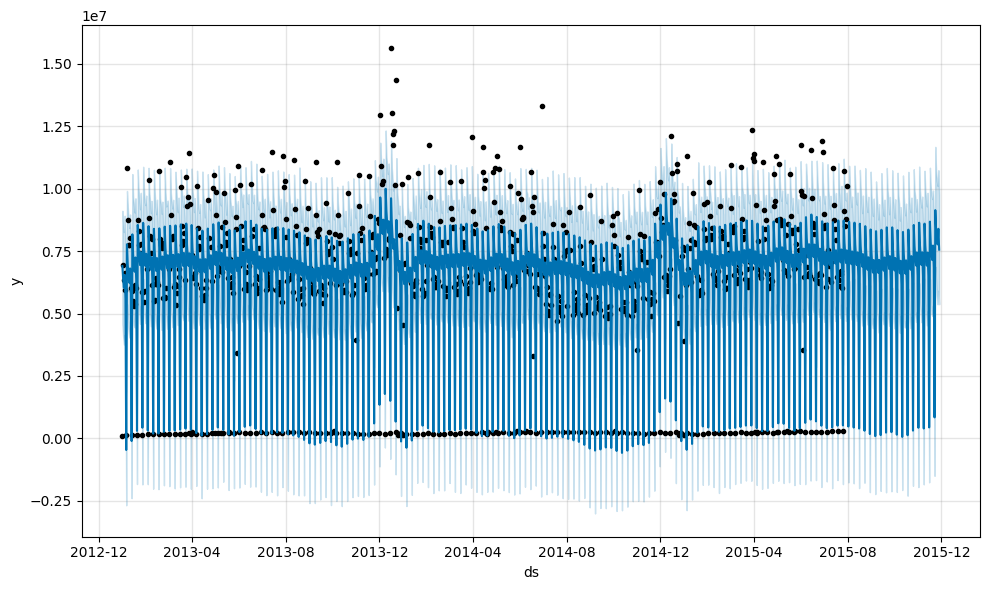

In [105]:
fig = model.plot(forecast)
plt.show()

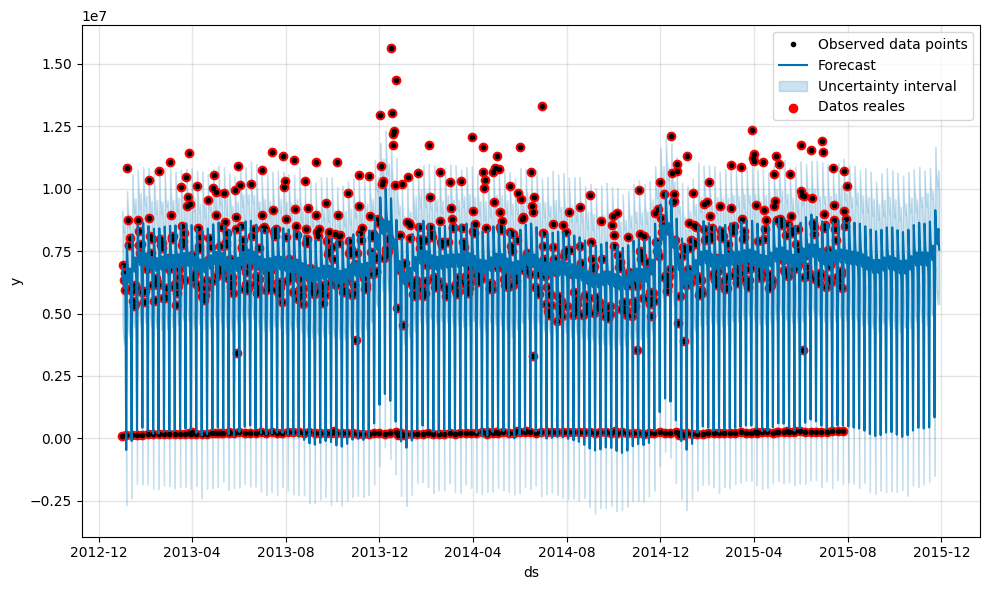

In [106]:
fig = model.plot(forecast)
plt.scatter(ds_prophet['ds'], ds_prophet['y'], color='red', label='Datos reales')
plt.legend()
plt.show()

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [108]:
predictions = forecast[forecast['ds'].isin(ds_prophet['ds'])]


In [109]:
mse = mean_squared_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])
mae = mean_absolute_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])

In [110]:
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 3216900421137.263
Error Absoluto Medio (MAE): 1224485.6880796237


Second analysisi

In [111]:
model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)

In [112]:
model.fit(ds_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/pzhn152f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/e7c49pq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29989', 'data', 'file=/tmp/tmp67ikel48/pzhn152f.json', 'init=/tmp/tmp67ikel48/e7c49pq_.json', 'output', 'file=/tmp/tmp67ikel48/prophet_modeljdv2hvut/prophet_model-20241010000416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [113]:
future = model.make_future_dataframe(periods=120)
forecast = model.predict(future)

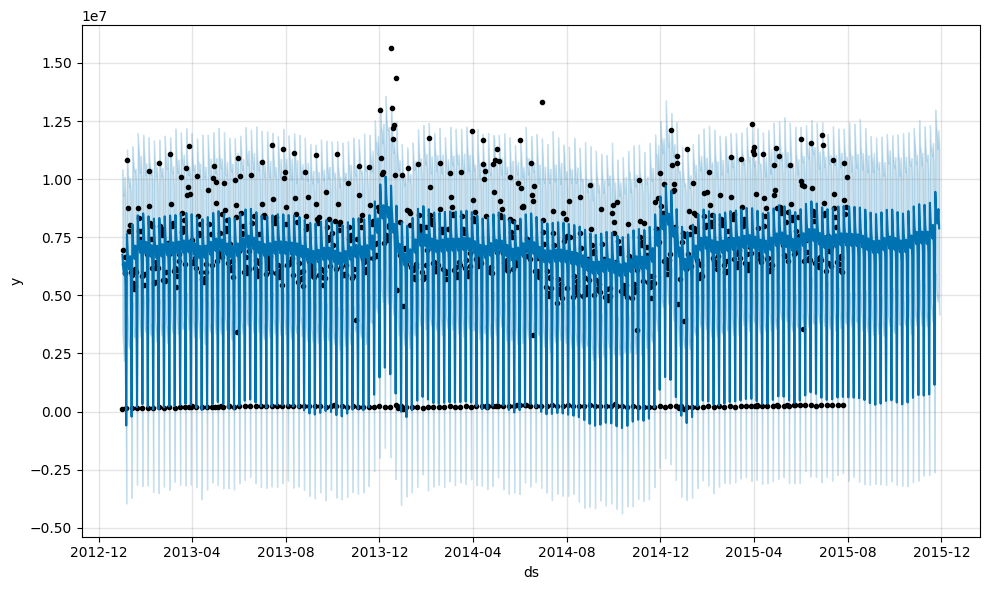

In [114]:
fig = model.plot(forecast)
plt.show()

In [115]:
predictions = forecast[forecast['ds'].isin(ds_prophet['ds'])]


In [116]:
mse = mean_squared_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])
mae = mean_absolute_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])

In [117]:
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 3192587395396.7925
Error Absoluto Medio (MAE): 1224273.3468527743


Tercer intento con holidays

In [118]:
holidays = pd.DataFrame({
    'holiday': [
        'Año Nuevo', 'Navidad', 'Viernes Santo', 'Día del trabajador', 'Día de la unidad alemana',  # Feriados de 2013
        'Año Nuevo', 'Navidad', 'Viernes Santo', 'Día del trabajador', 'Día de la unidad alemana',  # Feriados de 2014
        'Año Nuevo', 'Navidad', 'Viernes Santo', 'Día del trabajador', 'Día de la unidad alemana'   # Feriados de 2015
    ],
    'ds': pd.to_datetime([
        '2013-01-01', '2013-12-25', '2013-03-29', '2013-05-01', '2013-10-03',  # Feriados de 2013
        '2014-01-01', '2014-12-25', '2014-04-18', '2014-05-01', '2014-10-03',  # Feriados de 2014
        '2015-01-01', '2015-12-25', '2015-04-03', '2015-05-01', '2015-10-03'   # Feriados de 2015
    ]),
    'lower_window': [0] * 15,  # Ajustar para 15 elementos
    'upper_window': [1] * 15,  # Ajustar para 15 elementos
})

In [119]:
print(holidays)


                     holiday         ds  lower_window  upper_window
0                  Año Nuevo 2013-01-01             0             1
1                    Navidad 2013-12-25             0             1
2              Viernes Santo 2013-03-29             0             1
3         Día del trabajador 2013-05-01             0             1
4   Día de la unidad alemana 2013-10-03             0             1
5                  Año Nuevo 2014-01-01             0             1
6                    Navidad 2014-12-25             0             1
7              Viernes Santo 2014-04-18             0             1
8         Día del trabajador 2014-05-01             0             1
9   Día de la unidad alemana 2014-10-03             0             1
10                 Año Nuevo 2015-01-01             0             1
11                   Navidad 2015-12-25             0             1
12             Viernes Santo 2015-04-03             0             1
13        Día del trabajador 2015-05-01         

In [120]:
model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)


In [121]:
model.add_seasonality(name='cambio_estacion', period=365, fourier_order=5)


In [122]:
model.fit(ds_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/r6jixc5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/451sis89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34378', 'data', 'file=/tmp/tmp67ikel48/r6jixc5j.json', 'init=/tmp/tmp67ikel48/451sis89.json', 'output', 'file=/tmp/tmp67ikel48/prophet_model0sudf2ml/prophet_model-20241010000418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:04:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [123]:
future = model.make_future_dataframe(periods=120)
forecast = model.predict(future)

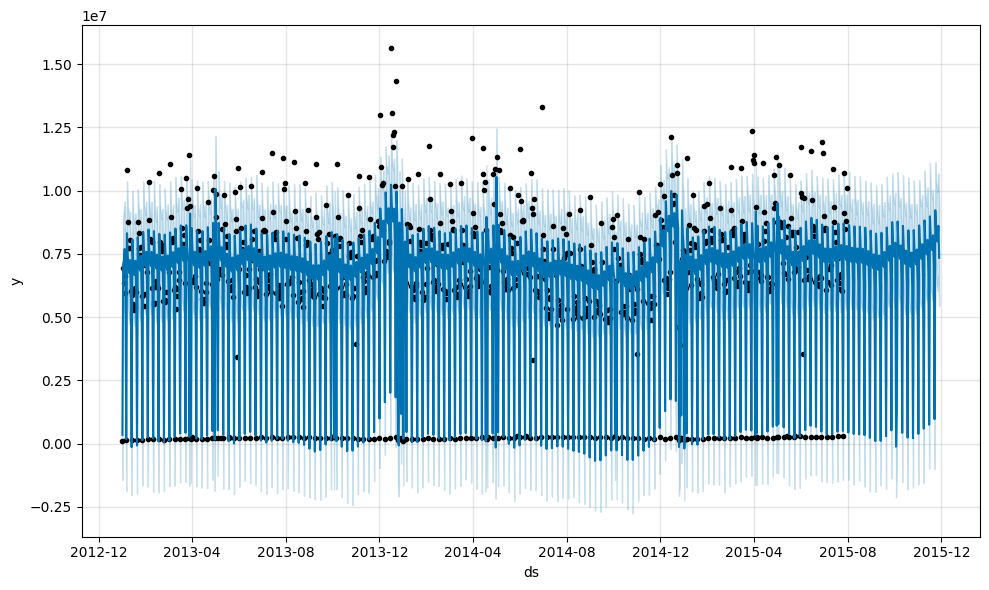

In [124]:
fig = model.plot(forecast)
plt.show()

In [125]:
predictions = forecast[forecast['ds'].isin(ds_prophet['ds'])]


In [126]:
mse = mean_squared_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])
mae = mean_absolute_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])

In [127]:
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 2337571300714.1504
Error Absoluto Medio (MAE): 1078426.9537239533


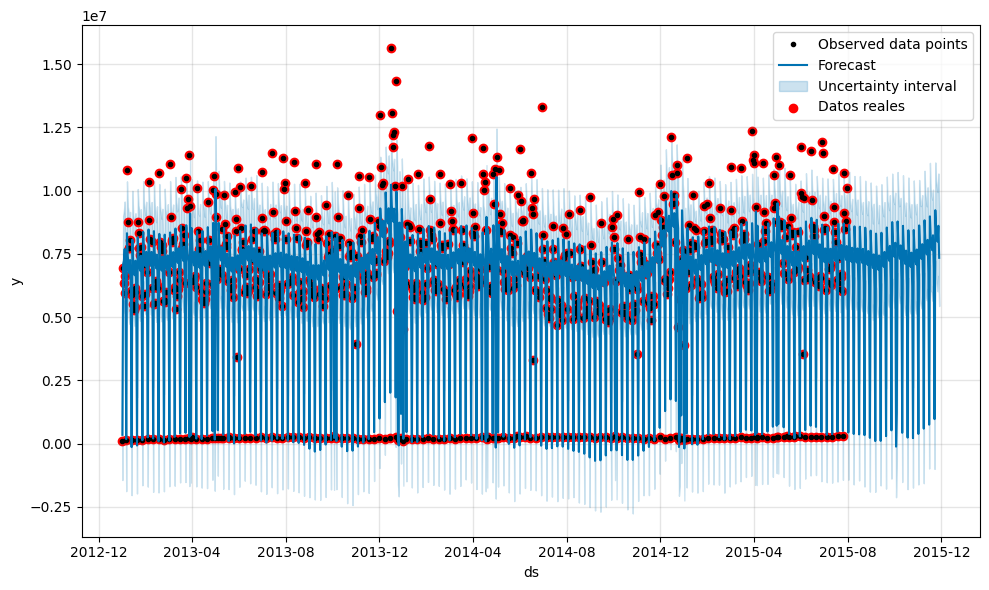

In [128]:
fig = model.plot(forecast)
plt.scatter(ds_prophet['ds'], ds_prophet['y'], color='red', label='Datos reales')
plt.legend()
plt.show()

Promo

In [129]:
daily_sales['Promo'] = daily_sales['Promo'].astype(float)

In [130]:
model = Prophet()


In [131]:
model.add_regressor('Promo')


In [132]:
model = Prophet(holidays=holidays)


In [133]:
model.fit(ds_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/gr3270wg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67ikel48/wdm_wkpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33930', 'data', 'file=/tmp/tmp67ikel48/gr3270wg.json', 'init=/tmp/tmp67ikel48/wdm_wkpt.json', 'output', 'file=/tmp/tmp67ikel48/prophet_model2aw3ptys/prophet_model-20241010000422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:04:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [134]:
future = model.make_future_dataframe(periods=120)
future['Promo'] = daily_sales['Promo'].iloc[-1]

In [135]:
forecast = model.predict(future)


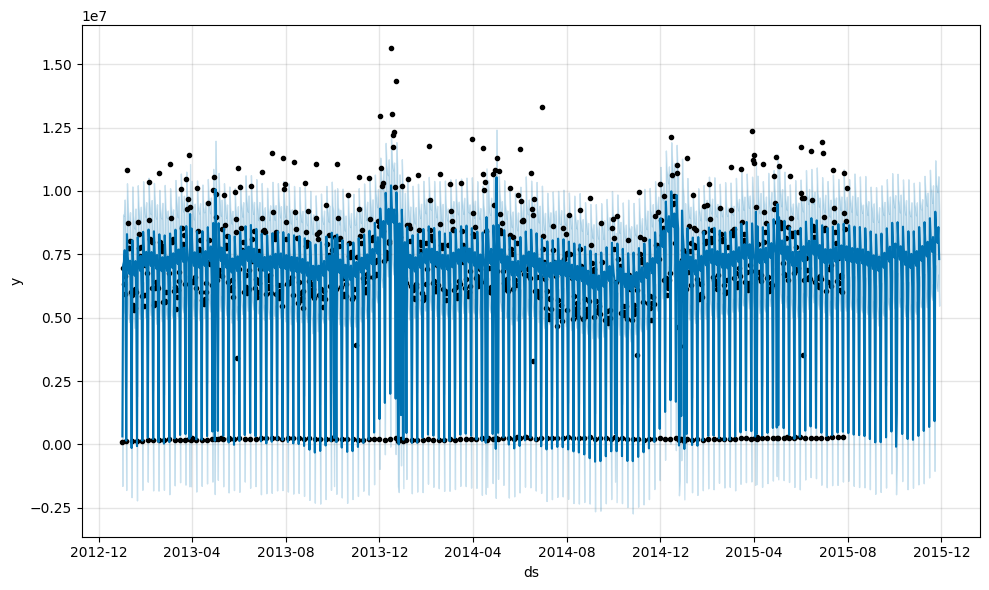

In [136]:
fig = model.plot(forecast)
plt.show()

In [137]:
future_pred = forecast[~forecast['ds'].isin(ds_prophet['ds'])]

In [138]:
mse = mean_squared_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])
mae = mean_absolute_error(predictions['yhat'], ds_prophet.loc[ds_prophet['ds'].isin(predictions['ds']), 'y'])

In [139]:
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 2337571300714.1504
Error Absoluto Medio (MAE): 1078426.9537239533


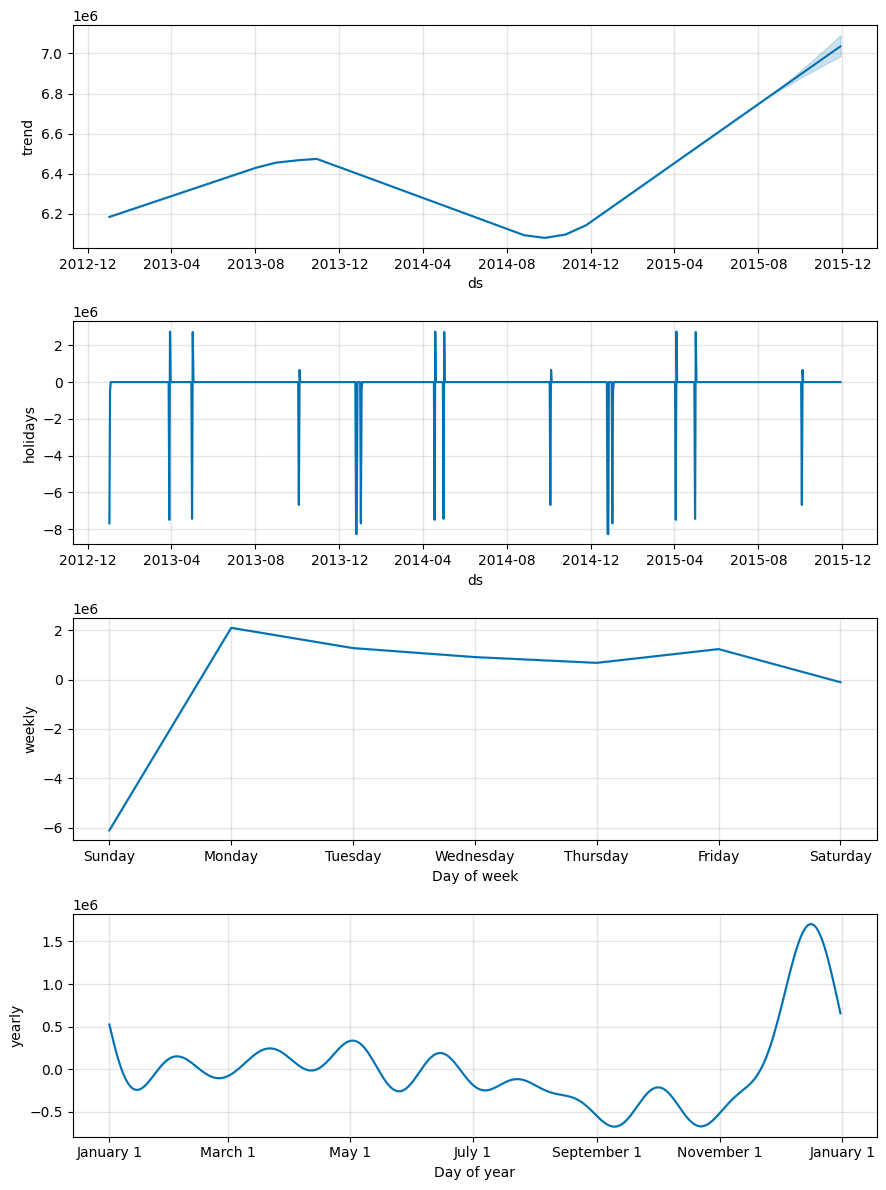

In [140]:
fig = model.plot_components(forecast)
plt.show()

*promo afeacta negativamente a la predicción